# Attention

Created by [Gerard I. Gállego](https://www.linkedin.com/in/gerard-gallego/), [Laia Tarrés](https://www.linkedin.com/in/laia-tarres/) and [Javier Ferrando](https://www.linkedin.com/in/javierferrandomonsonis/) for the [Postgraduate Course in Artificial Intelligence with Deep Learning](https://www.talent.upc.edu/ing/estudis/formacio/curs/310400/postgrau-artificial-intelligence-deep-learning/) ([UPC School](https://www.talent.upc.edu/ing/), 2022).

Updated by [Ioannis Tsiamas](https://www.linkedin.com/in/i-tsiamas/) (2023).


Resources:

*   [This book, that has a chapter on attention](https://d2l.ai/chapter_attention-mechanisms-and-transformers/index.html)
*   [Lab 1: Attention](https://colab.research.google.com/github/whitead/dmol-book/blob/master/dl/attention.ipynb#scrollTo=DzqrgWQMv3nQ)
*   [Lab 2: Attention transformer intuition](https://colab.research.google.com/github/alvinntnu/NTNU_ENC2045_LECTURES/blob/main/nlp/dl-attention-transformer-intuition.ipynb#scrollTo=yG-ivNKJYTkE)
*   [This article is very well explained](https://lilianweng.github.io/posts/2018-06-24-attention/)
*   [This colab for RNN + attention](https://colab.research.google.com/drive/1eObkehym2HauZo-NBYi39aAsWE1ujExk?usp=sharing#scrollTo=roXSIRB_QWDr)
*   [This video tutorial on attention](https://youtu.be/w0OZ5iHsamk)



In this lab we are going to learn about Attention.

Attention is a concept in machine learning and AI that goes back many years.
Attention was inspired by how human brains deal with the massive amount of visual and audio input.
As humans, we are not capable of processing all visual and audio inputs. Instead, we select - or attend to - the important parts of the input to be able make sense of our surroundings.

For example, to detect there's a shiba inu dog in the following picture, we focus on the different elements in the face:

![shiba attention](https://lilianweng.github.io/posts/2018-06-24-attention/shiba-example-attention.png)

In [1]:
from __future__ import unicode_literals, print_function, division

import re
import math
import random
import string
import unicodedata
from io import open

import numpy as np

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import seaborn as sns

To ensure reproducibility of the experiments, we can set the seed to a fixed number.

In [2]:
seed = 123
np.random.seed(seed)
_ = torch.manual_seed(seed)
_ = torch.cuda.manual_seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
def plot_attention(attention, xtitle="Keys", ytitle="Queries"):
    """ Plots the attention map."""

    sns.set(rc={'figure.figsize':(12, 8)})
    ax = sns.heatmap(
        attention.detach().cpu(),
        linewidth=0.5,
        cmap="Blues",
        square=True)

    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    ax.set_xlabel(xtitle)
    ax.set_ylabel(ytitle)

    plt.show()

# Attention Mechanisms

https://www.kdnuggets.com/2021/01/attention-mechanism-deep-learning-explained.html

In deep learning context, attention is a term used for a family of related mechanisms which, in general, learn to predict some probability distribution over a sequence of elements.

Intuitively, this allows a model to "pay more attention" to elements from the sequence which get a higher probability weight.

In this lab, we are going to dive deep into the **soft-attention** mechanism, the standard approach nowadays. We are going to also try different versions of it, the *additive*, and the multiplicative attentions.

An attention mechanism has a least the following components:

*   n key-value pairs:  {${(k_i, v_i)}$} $_{i=1}^n$ where $k_i \in ℝ^{d_k}$ and $v_i \in ℝ^{d_v}$, representing the same elements in the sequence
*   A query: $q \in ℝ^{d_q}$
*   Some similarity function (sometimes called *energy*) between keys and queries: $e :  ℝ^{d_k}$ x $ℝ^{d_q}$




## How the attention output is calculated?

### Soft-attention mechanism

A soft-attention mechanism performs a linear combination of the values. The weights associated with each value in the linear combination are computed by comparing the query with every key. The more similar the query is to the key, the larger the weight of the associated value in the attention output.

More formally, the output of the attention mechanism is computed as:
$ o = \sum_{i=1}^n a_i v_i \in ℝ^{d_v}$

Each attention weights $a_i$ is computed by measuring the similarity between the query and the $i$-th key. First we obtain
$b_i = e(k_i,q)$, and then, by applying $e$ to all $i$, we get a vector $b = [b_1,...,b_n]^T$, which is transformed into the probability simplex thanks to the softmax function, $a = \text{softmax} (b)$.

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/soft_attention.png?raw=true" class="center" title="Soft-attention mechanism" width="600"/>
</p><br>

# How is the query-key comparison calculated?

# Exercise 1: MultiplicativeAttention

The multiplicative attention performs the following operation:

$e(k,q) = q W_q k^T$

We use a learnable matrix between the query and the key. This is equivalent to projecting the query through $W_q$ and performing the dot-product afterwards.

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/multiplicative_attention.png?raw=true" class="center" title="Mutliplicative attention" width="300"/>
</p><br>

Let's create one random query, and eight random keys and values, with the following dimensions:
- $T_Q=1$
- $T_K=T_V=8$
- $d_Q=d_K=d_V=128$

Let's consider keys and values as representing the same element.

In [4]:
dim = 128
q = torch.randn(1, dim)
k = torch.randn(8, dim)
v = k

### Training loop with a dummy task

Let's now specify our training function. Since some attention types have learnable weight matrices, we can then train them to accomplish a specific task. Here we define an optimizer (Adam), a loss function (Mean Square Error), and perform a training loop to minimize the distance between the model `output` and the desired `target`.

As a use case to check if the model works well, we are going to define the `target` as a linear combination of the values, with `target_attn_weights` as weights. That is, we force the model to compute:

$ \text{target} = \sum_{i=1}^n \text{target_attn_weights } v_i \in ℝ^{d_v}$

If we recall the output equation of the attention:

$ o = \sum_{i=1}^n a_i v_i \in ℝ^{d_v}$

we can see that if the model learns to output `target`, we expect it to find attention weights $a= \text{target_attn_weights}$.

Note that the `mse_loss` measures the distance between each component of `target` and `output`.

In [5]:
def dummy_train(attn_module, q, k, v, target_attn_weights):
    optimizer = optim.Adam(attn_module.parameters(), lr=0.0001)

    target = torch.matmul(target_attn_weights, v)

    attn_module.train()

    n_epochs = 15000
    for i in range(n_epochs):
        optimizer.zero_grad()
        output, attn_weights = attn_module(q, k, v)
        loss = F.mse_loss(output, target)
        loss.backward()
        optimizer.step()

        if (i + 1) % 1000 == 0:
            print(f"Epoch {i+1}/{n_epochs}")
            print(f"\tLoss:\t\t{loss.item()}")
            print(f"\tAttention:\t{attn_weights.squeeze().detach().numpy().round(3)}")


    attn_module.eval()
    output, attn_weights = attn_module(q, k, v)

    print(f"\nOutput:\n{output}\n")
    print(f"\nTarget:\n{target}\n")

    return output, attn_weights

In [6]:
class MultiplicativeAttention(nn.Module):
    """
     Implements plain dot-product and multiplicative attention.
     Args:
         q_dim (int): dimension of the queries
         k_dim (int): dimension of the keys
         v_dim (int): dimension of the values
         scaling (bool): whether to scale after the dot-product
         sub_type (string): specify type of attention: dot-product / multiplicative
     Inputs: query, key, value
        query (torch.FloatTensor):  Query Tensor   (... x T_q x d_q)
        key (torch.FloatTensor):  Key Tensor     (... x T_k x d_k)
        value (torch.FloatTensor):  Value Tensor   (... x T_v x d_v)

    Returns:
        torch.FloatTensor: Result of the Attention Mechanism  (... x T_q x d_v)
        torch.FloatTensor: Attention map       (... x T_q x T_k)

    """
    def __init__(self, q_dim: int, k_dim: int, scaling: bool = False, sub_type: str = 'multiplicative') -> None:
        super(MultiplicativeAttention, self).__init__()
        self.sub_type = sub_type
        if self.sub_type == 'dot_product':
            assert q_dim == k_dim
            self.scaling = scaling
        else:
          self.proj_w = nn.Linear(q_dim, k_dim, bias=False)
          self.scaling = False                                  # We don't scale in the multiplicative attention

    def forward(self, query, key, value):
        if self.sub_type == 'dot_product':
            qw = query
            key_ = key

        else:
            qw = self.proj_w(query)                             # (... x T_q x q_dim) -> (... x T_q x k_dim)
            key_ = key

        # TODO: Compute the attention logits from qw and the key
        # (... x T_q x k_dim) * (... x k_dim x T_k) -> (... x T_q x T_k)
        attn_logits = torch.matmul(qw, key_.transpose(-2, -1))

        if self.scaling:
            attn_logits = attn_logits / math.sqrt(key_.size(-1))

        # TODO: Compute the attention weights
        attn_weights = torch.softmax(attn_logits, dim=-1)

        output = torch.matmul(attn_weights, value)
        return output, attn_weights

In [7]:
target_attn_weights = torch.Tensor([[0.1, 0.2, 0.1, 0.3, 0.0, 0.2, 0.0, 0.1]])

attn_module = MultiplicativeAttention(q_dim=dim, k_dim=dim)
output, attn_weights = dummy_train(attn_module, q, k, v, target_attn_weights)

Epoch 1000/15000
	Loss:		0.010262658819556236
	Attention:	[0.    0.222 0.114 0.312 0.016 0.201 0.022 0.112]
Epoch 2000/15000
	Loss:		0.01026249397546053
	Attention:	[0.    0.222 0.114 0.312 0.016 0.201 0.022 0.112]
Epoch 3000/15000
	Loss:		0.010261950083076954
	Attention:	[0.    0.222 0.114 0.312 0.016 0.201 0.022 0.112]
Epoch 4000/15000
	Loss:		0.010495520196855068
	Attention:	[0.    0.229 0.115 0.3   0.016 0.202 0.022 0.114]
Epoch 5000/15000
	Loss:		3.297360672149807e-05
	Attention:	[0.1   0.202 0.1   0.295 0.001 0.2   0.    0.101]
Epoch 6000/15000
	Loss:		0.00021711509907618165
	Attention:	[0.101 0.206 0.101 0.288 0.    0.201 0.    0.102]
Epoch 7000/15000
	Loss:		0.00014430732699111104
	Attention:	[0.101 0.205 0.1   0.29  0.    0.202 0.    0.102]
Epoch 8000/15000
	Loss:		8.686295768711716e-05
	Attention:	[0.099 0.195 0.1   0.307 0.    0.2   0.    0.099]
Epoch 9000/15000
	Loss:		4.210452243569307e-05
	Attention:	[0.101 0.203 0.1   0.295 0.    0.2   0.    0.101]
Epoch 10000/15000
	Los

We can see that the model is able to learn to produce an `output` vector very similar to `target` vector, and the attention weights converge to `target_attn_weights`.

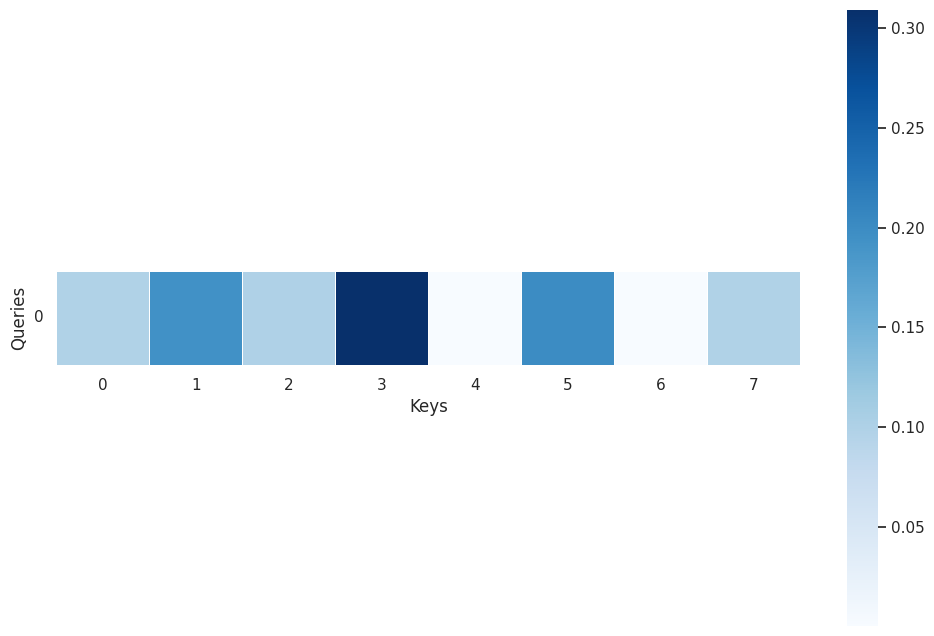

In [8]:
# Plot attention weights of trained attention

output, attention = attn_module(q,k,v)

plot_attention(
    attention,
)

## Dot-product attention

One basic type of attention mechanism, called dot-product attention, uses a simple dot product as a similarity function.

This is the most commonly used type of attention nowadays, as it is used by models based on the Transformer architecture.

$e(k,q) = k^T q$

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/dot_product_attn.png?raw=true" class="center" title="Dot-product attention" width="300"/>
</p><br>

The dot-product grows due to the dimensionality. Scaling can help reducing the sharpness of the probability distribution after applying the softmax, and therefore prevent tiny gradients. Assuming $d_k = d_q = d$ (all the dimensions are identical), then:

$e(k,q) = \frac{k^T q}{\sqrt{d}}$

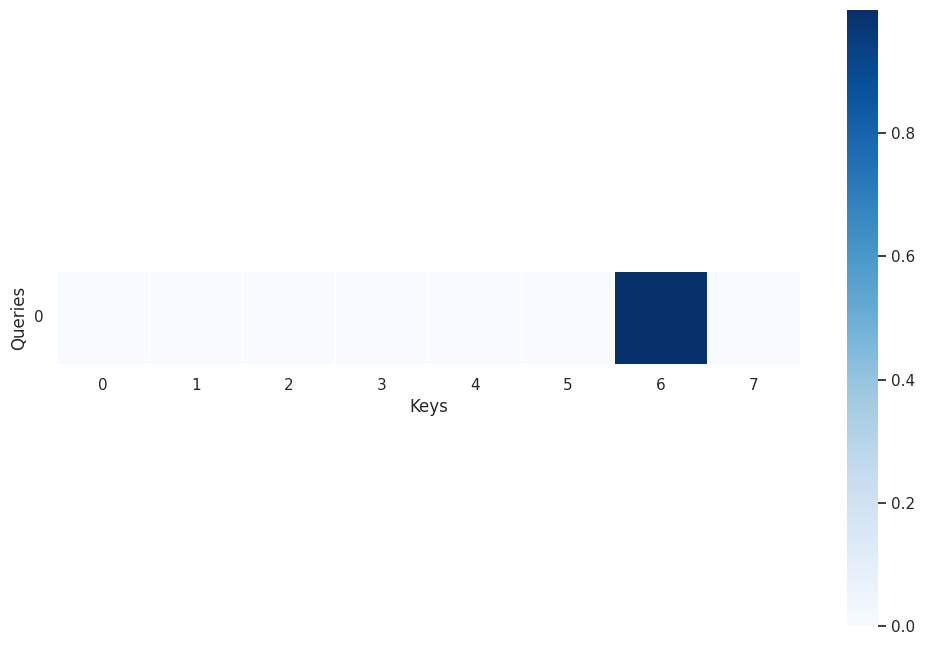

In [9]:
attn_module = MultiplicativeAttention(q_dim=dim, k_dim=dim, sub_type='dot_product')
output, attention_no_scaling = attn_module(q,k,v)

plot_attention(
    attention_no_scaling,
)

We use ```scaling``` argument to choose wether we also want to scale after the dot-product.

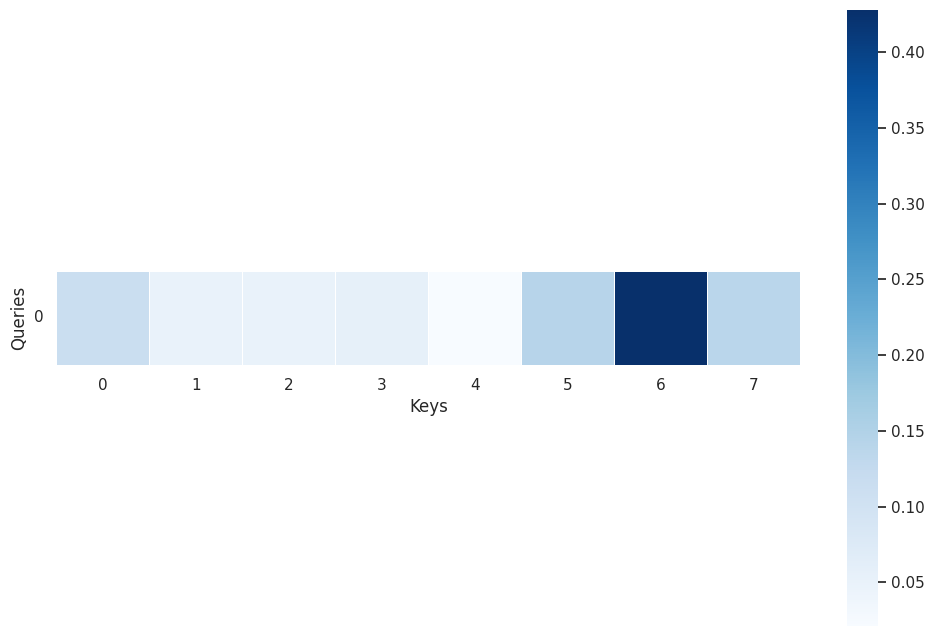

In [10]:
attn_module = MultiplicativeAttention(q_dim=dim, k_dim=dim, sub_type='dot_product', scaling = True)
output, attention_scaling = attn_module(q,k,v)

plot_attention(
    attention_scaling,
)

You can see that the distribution of attention weights changes, right?
Let's use a bar plot to compare them better:

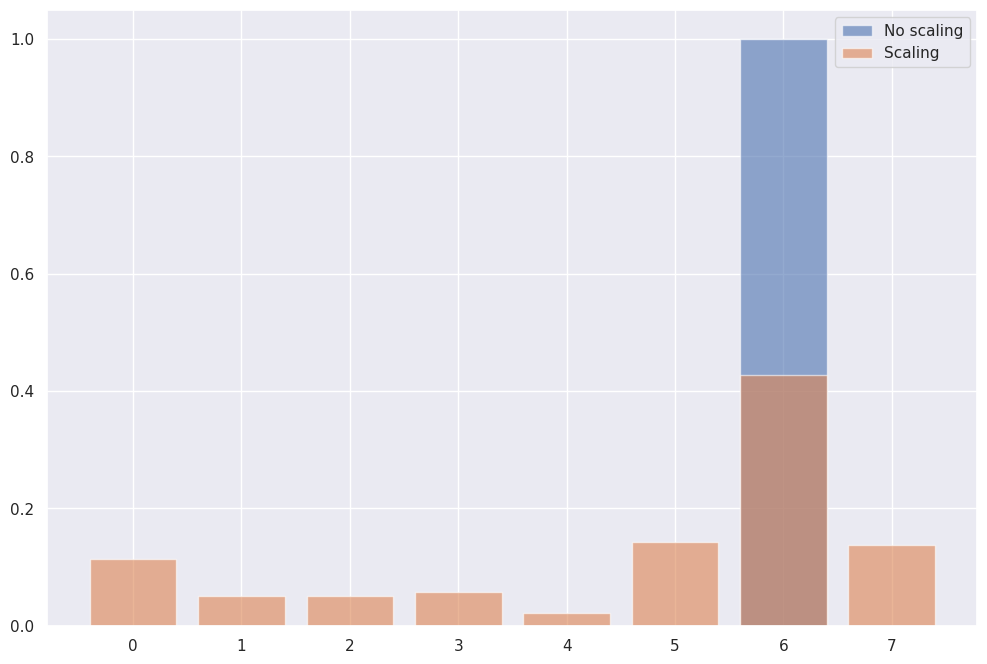

In [11]:
def plot_histogram(input_tensor_dict):
    """Helper function to make bar plots."""
    for key in input_tensor_dict.keys():
      input_tensor = input_tensor_dict[key].squeeze().cpu().detach().numpy()
      plt.bar(range(0,input_tensor.size),input_tensor, alpha=0.6, label = key)
    plt.xticks(ticks = range(0,input_tensor.size))
    plt.legend()

attn_results_dict = {'No scaling' : attention_no_scaling, 'Scaling' : attention_scaling}
plot_histogram(attn_results_dict)

# Exercise 2: Additive attention

In this case, the attention mechanism uses an MLP to learn the similarity function $e(k,q) = tanh(k W_k + q W_q) w^T$ where $W_k \in ℝ^{h𝘟d_k}$, $W_q \in ℝ^{h𝘟d_q}$ and $w \in ℝ^{h}$ are trainable parameters.

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/additive_attention.png?raw=true" class="center" title="Additive attention" width="700"/>
</p><br>

Here we don't assume that the queries and keys have the same dimensionality, because we can project them into a space of a fixed dimension through $W_k$ and $W_q$. Then this is our first layer of the MLP. And then we have the second layer with is just a linear output layer.

Notice that we are adding projected versions of the key and query and applying a 2-layer MLP. Both projections and the output layer are trainable.


In [12]:
class AdditiveAttention(nn.Module):
    """
     Implements the additive attention as proposed in "Neural Machine Translation by Jointly Learning to Align and Translate".
     Args:
         q_dim (int): dimesion of the queries
         k_dim (int): dimesion of the keys
         attn_dim (int): dimension of intermediate vectors

     Inputs: query, key, value
        query (torch.FloatTensor):  Query Tensor   (... x T_q x d_q)
        key (torch.FloatTensor):  Key Tensor     (... x T_k x d_k)
        value (torch.FloatTensor):  Value Tensor   (... x T_v x d_v)

    Returns:
        torch.FloatTensor: Result of the Attention Mechanism  (... x T_q x d_v)
        torch.FloatTensor: Attention map       (... x T_q x T_k)

    """
    def __init__(self, q_dim: int, k_dim: int, attn_dim: int) -> None:
        super(AdditiveAttention, self).__init__()

        # TODO: Create projections of queries and keys
        self.proj_q = nn.Linear(q_dim, attn_dim, bias=False)
        self.proj_k = nn.Linear(k_dim, attn_dim, bias=False)


        self.bias = nn.Parameter(torch.rand(attn_dim).uniform_(-0.1, 0.1))
        self.w = nn.Linear(attn_dim, 1)

    def forward(self, query, key, value):
        q_ = self.proj_q(query) # (... x T_q x q_dim) -> (... x T_q x attn_dim)
        k_ = self.proj_k(key)   # (... x T_k x k_dim) -> (... x T_k x attn_dim)

        # Prepare for Broadcasting Semantics
        q_ = q_.unsqueeze(-2)   # (... x T_q x attn_dim) -> (... x T_q x  1  x attn_dim)
        k_ = k_.unsqueeze(-3)   # (... x T_k x attn_dim) -> (... x  1  x T_k x attn_dim)

        # Sum thanks to Broadcasting Semantics
        attn_hid = torch.tanh(q_ + k_ + self.bias) # (... x T_q x  1  x attn_dim) + (... x  1  x T_k x attn_dim) + (attn_dim) -> (... x T_q x T_k x attn_dim)

        attn_logits = self.w(attn_hid)        # (... x T_q x T_k x attn_dim) -> (... x T_q x T_k x 1)
        attn_logits = attn_logits.squeeze(-1) # (... x T_q x T_k x 1) -> (... x T_q x T_k)

        attn_weights = F.softmax(attn_logits, dim=-1)

        # TODO: Compute the output of the attention
        output = torch.matmul(attn_weights, value)

        return output, attn_weights

In [13]:
target_attn_weights = torch.Tensor([[0.1, 0.2, 0.1, 0.3, 0.0, 0.2, 0.0, 0.1]])

attn_module = AdditiveAttention(q_dim=dim, k_dim=dim, attn_dim=dim//2)

output, attn_weights = dummy_train(attn_module, q, k, v, target_attn_weights)

Epoch 1000/15000
	Loss:		7.584554987261072e-05
	Attention:	[0.098 0.198 0.099 0.298 0.006 0.198 0.005 0.099]
Epoch 2000/15000
	Loss:		1.8587958038551733e-05
	Attention:	[0.099 0.199 0.099 0.299 0.003 0.199 0.002 0.099]
Epoch 3000/15000
	Loss:		7.584767445223406e-06
	Attention:	[0.099 0.2   0.1   0.299 0.002 0.199 0.002 0.1  ]
Epoch 4000/15000
	Loss:		3.76242860511411e-06
	Attention:	[0.099 0.2   0.1   0.3   0.001 0.199 0.001 0.1  ]
Epoch 5000/15000
	Loss:		2.032893235082156e-06
	Attention:	[0.1   0.2   0.1   0.3   0.001 0.2   0.001 0.1  ]
Epoch 6000/15000
	Loss:		1.1457494792921352e-06
	Attention:	[0.1   0.2   0.1   0.3   0.001 0.2   0.001 0.1  ]
Epoch 7000/15000
	Loss:		6.730432460244629e-07
	Attention:	[0.1   0.2   0.1   0.3   0.001 0.2   0.    0.1  ]
Epoch 8000/15000
	Loss:		4.253098779827269e-07
	Attention:	[0.1 0.2 0.1 0.3 0.  0.2 0.  0.1]
Epoch 9000/15000
	Loss:		2.6630823413142934e-07
	Attention:	[0.1 0.2 0.1 0.3 0.  0.2 0.  0.1]
Epoch 10000/15000
	Loss:		1.834227134622779e-07
	

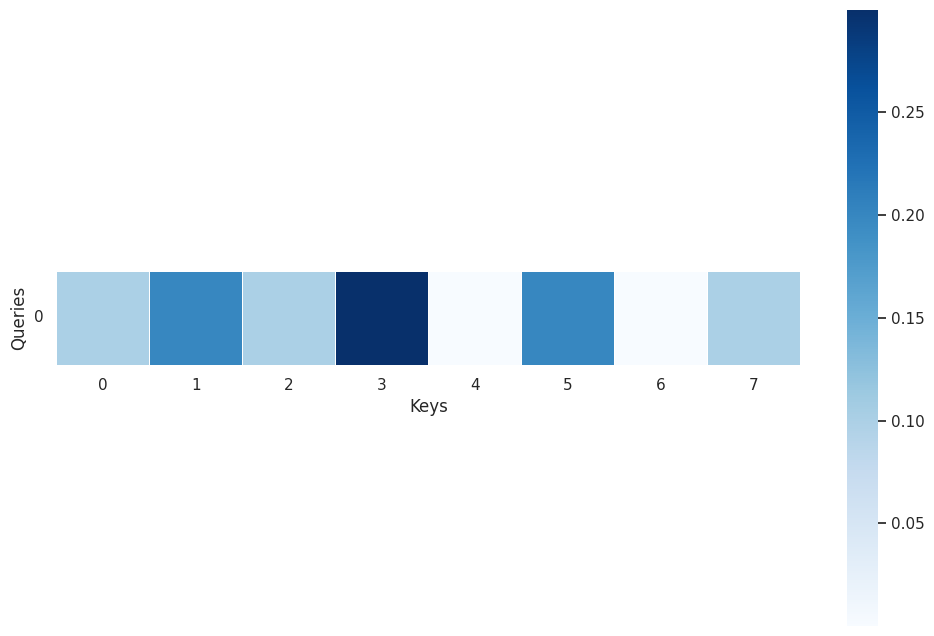

In [14]:
# Plot attention weights of trained attention
output, attention = attn_module(q,k,v)

plot_attention(
    attention,
)

# Attention with matrices

In the previous excercises we have used only one query. However, in reality, we deal with $m$ queries simultaneously. We can define a stack of queries as a matrix $Q \in ℝ^{m𝘟d_q}$.

Similarly, we'll stack the keys and values in their own matrices $K \in ℝ^{n𝘟d_k}$ $V \in ℝ^{n𝘟d_v}$

Then we can compute the attention weights for all the queries in parallel:

$B = \frac{1}{\sqrt{d}}QK^T$

$A = \text{softmax}(B)$, all the weights in each row sum 1

$O = AV \in ℝ^{m𝘟d_v}$

Just like before, the output is still the weighted sum of the values scaled by the attention.
This is computed by each query, so for each of the $m$ input queries we have an output value, a row in $O$.

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/attention_matrices.png?raw=true" class="center" title="Attention with matrices" width="500"/>
</p><br>

Let's now define a query matrix Q, with three queries, one per row.

In [15]:
dim = 128
q = torch.randn(3, dim)
k = torch.randn(8, dim)
v = k

Our dummy task now has to predict one `target` vector per each query:

In [16]:
target_attn_weights = torch.Tensor([[0.1, 0.2, 0.1, 0.3, 0.0, 0.2, 0.0, 0.1],
                                    [0.4, 0.1, 0.1, 0.2, 0.0, 0.2, 0.0, 0.0],
                                    [0.0, 0.6, 0.0, 0.1, 0.0, 0.2, 0.0, 0.1]])

attn_module = AdditiveAttention(q_dim=dim, k_dim=dim, attn_dim=dim//2)

output, attn_weights = dummy_train(attn_module, q, k, v, target_attn_weights)

Epoch 1000/15000
	Loss:		0.0004545650153886527
	Attention:	[[0.097 0.197 0.096 0.299 0.008 0.199 0.007 0.096]
 [0.396 0.091 0.092 0.191 0.009 0.196 0.009 0.016]
 [0.012 0.59  0.01  0.091 0.005 0.194 0.006 0.092]]
Epoch 2000/15000
	Loss:		0.00012629390403162688
	Attention:	[[0.099 0.198 0.098 0.299 0.005 0.199 0.004 0.098]
 [0.398 0.096 0.096 0.195 0.004 0.198 0.004 0.009]
 [0.006 0.595 0.005 0.095 0.003 0.197 0.003 0.096]]
Epoch 3000/15000
	Loss:		5.294075162964873e-05
	Attention:	[[0.099 0.199 0.099 0.299 0.003 0.199 0.003 0.099]
 [0.399 0.097 0.097 0.197 0.003 0.199 0.003 0.006]
 [0.004 0.597 0.003 0.097 0.002 0.198 0.002 0.098]]
Epoch 4000/15000
	Loss:		2.6260537197231315e-05
	Attention:	[[0.099 0.199 0.099 0.299 0.002 0.2   0.002 0.099]
 [0.399 0.098 0.098 0.198 0.002 0.199 0.002 0.004]
 [0.003 0.598 0.002 0.098 0.001 0.199 0.001 0.098]]
Epoch 5000/15000
	Loss:		1.4133875993138645e-05
	Attention:	[[0.099 0.199 0.099 0.3   0.002 0.2   0.002 0.1  ]
 [0.399 0.099 0.099 0.198 0.001 0.1

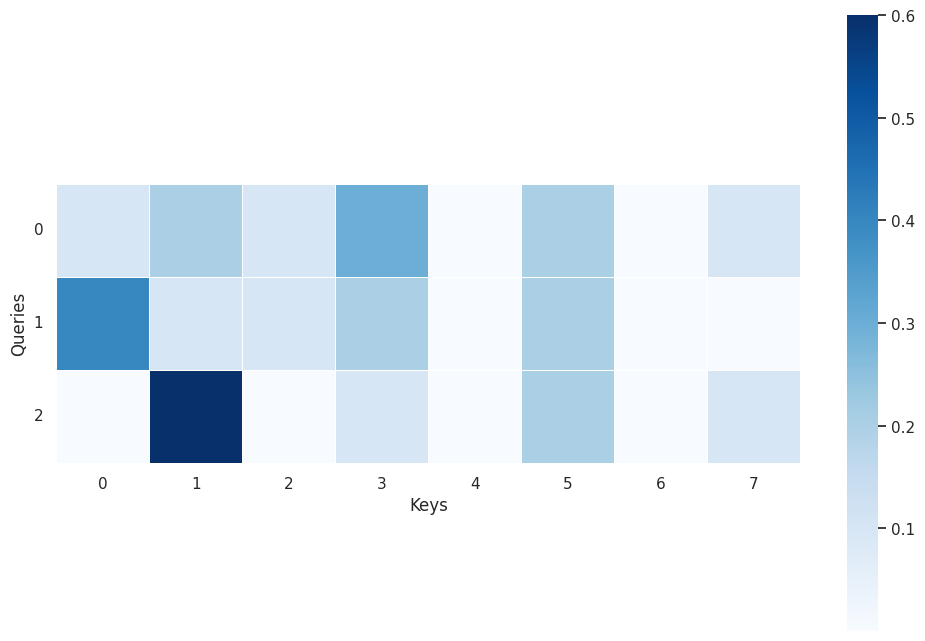

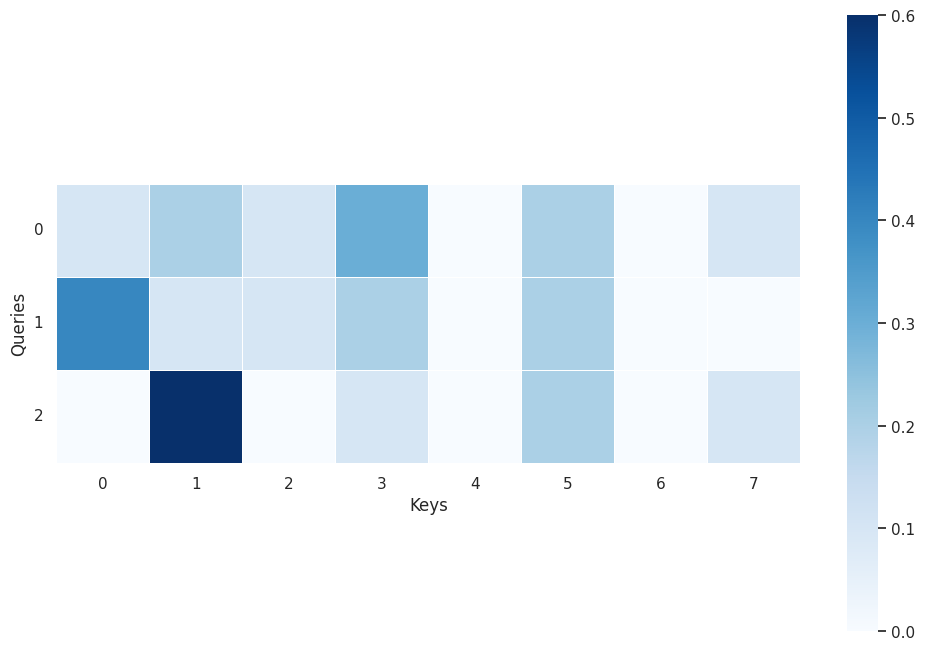

In [18]:
# Plot attention weights of trained attention
output, attention = attn_module(q,k,v)

plot_attention(
    attention,
)
plot_attention(target_attn_weights)

# Exercise 3: Neural Machine Translation with RNNs and attention

# Sequence-to-sequence Models

To better motivate the use of attention, we are going to introduce a new family of models, the sequence-to-sequence, or se2seq, models. As the name suggests, seq2seq models map sequences to sequences, but both of arbitrary length.

This systems usually use an encoder-decoder architecture, composed of:

*   Encoder: processes the input sequence and compresses information into a context vector of fixed length. This embedding is a summary of the whole source sentence.
*   Decoder: it takes the context vector and produces the transformed output.

A classic example of seq2seq models are Machine Translation (MT) models. In this task, we deal with an input sequence corresponding to a sentence in the *source* language, and we aim to produce a translation in a *target* language:

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/enc_dec_gif_mt.gif?raw=true" class="center" title="NMT decoding gift" width="500"/>
</p><br>

Note that we generate the target sentence *autoregressively*, i.e. at each decoding step we produce a single word.

In order to correctly translate, at each decoding step humans usually pay attention to different parts of the source sentence, leaving the rest aside. This is the intuition behind the attention mechanism.

### Bottleneck Problem
The seq2seq architecture can be implemented with RNNs. However there is a main issue with this models: the decoder only uses the **last** state of the encoder as a context vector of the source sentence.

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/bottleneck_problem.png?raw=true" class="center" title="Bottleneck problem" width="500"/>
</p><br>

Why is this a problem? Since the last state of the encoder is of fixed size, it is not able to store the information of long sentences, and it often forgets the first parts once it completes processing the whole input.

Rather than building a single context vector out of the encoder's last hidden state, the attention mechanism creates shortcuts between each hidden state in the decoder and the entire source input. And this shortcuts are customizable for each output element.

In this lab, we are going to build a seq2seq model for translating text from English to Catalan, and will eventually visualize the attention patterns discovered by the model.

## Download dataset

In [ ]:
!wget http://www.manythings.org/anki/cat-eng.zip
!unzip cat-eng.zip && rm cat-eng.zip
!mkdir data
!mv "cat.txt" "data/eng-cat.txt"

In [ ]:
SOS_token = 0
EOS_token = 1

class Lang:
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # Count SOS and EOS

    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

## Data pre-processing

First we need to pre-process the raw text data. We need to make sure to lowercase all of it, remove all non-letter characters, and limit the maximum lenght of the sentences to MAX_LENGTH. Eventually, we create ```pairs```, a list where each component has a sentence and its translation, both pre-processed.



In [ ]:
# Turn a Unicode string to plain ASCII, thanks to
# http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
    )

# Lowercase, trim, and remove non-letter characters
def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # Read the file and split into lines
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # Remove extra info
    new_lines = []
    for line in lines:
        new_lines.append(line[0:(line.find('CC-BY')-1)])


    # Split every line into pairs and normalize
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in new_lines]

    # Reverse pairs, make Lang instances
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and \
        len(p[1].split(' ')) < MAX_LENGTH

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'cat', False)
print(random.choice(pairs))

We have a total of 1306 pairs of sentences containing 1436 english words and 1773 catalan words. We use a very small dataset to reduce training time, but a larger dataset would be necessary to learn something meaningful.

## Building the seq2seq model

We proceed to build our seq2seq model with attention. First we define our encoder RNN:

In [ ]:
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        # TODO: Define the Embedding matrix (use nn.Embedding)
        self.embedding = ...

        self.gru = nn.GRU(hidden_size, hidden_size, batch_first=True)

    def forward(self, input, hidden):
        embedded = self.embedding(input)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

Now we define our decoder, with an attention mechanism (```self.attn```) built inside. Try to map the code with the following diagram:

<p align="center"><br>
<img src="https://github.com/telecombcn-dl/labs-all/raw/main/labs/attention/images/attention_tensor_dance_last.jpeg?raw=true" class="center" title="Decoding with attention" width="800"/>
</p><br>

In [ ]:
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, batch_first=True)
        self.dropout = nn.Dropout(self.dropout_p)
        # Here we define the attention we use
        self.attn = AdditiveAttention(self.hidden_size, self.hidden_size, self.hidden_size // 2)
        #self.attn = MultiplicativeAttention(self.hidden_size, self.hidden_size)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input)
        embedded = self.dropout(embedded)

        x, hidden = self.gru(embedded, hidden)
        context, attn_weights = self.attn(query=x, key=encoder_outputs, value=encoder_outputs)

        # TODO: compute concatenation of the decoder hidden states and the context vectors
        x_w_context = ...

        x_w_context = self.attn_combine(x_w_context)
        output = F.log_softmax(self.out(x_w_context), dim=-1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(1, -1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

In [ ]:
def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

    # First hidden state used by the decoder is the last encoder hidden state
    decoder_hidden = encoder_hidden

    # We feed the decoder with the whole target sentence (teacher forcing),
    # first we append SOS_token
    decoder_input = torch.cat([
        torch.tensor([[SOS_token]], device=device),
        target_tensor[:, :-1]
    ], dim=1)


    decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)

    loss = criterion(
        decoder_output.view(-1, decoder_output.size(-1)),
        target_tensor.view(-1)
    )
    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_tensor.numel()

In [ ]:
import time

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    # this locator puts ticks at regular intervals
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # Reset every print_every
    plot_loss_total = 0  # Reset every plot_every

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate)
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate)

    # Random sample of n_iters pairs
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

In [ ]:
hidden_size = 256
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 50000, print_every=3000)

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        encoder_hidden = encoder.initHidden()

        encoder_outputs, encoder_hidden = encoder(input_tensor, encoder_hidden)

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = []

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions.append(decoder_attention.squeeze(0).data)
            topv, topi = decoder_output.data.topk(1)
            if topi.squeeze().item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.squeeze().item()])
            decoder_input = topi.detach().squeeze(1)

        return decoded_words, torch.cat(decoder_attentions)

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('Source:', pair[0])
        print('Reference:', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words[:-1])
        print('Model:', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder1, attn_decoder1)

In [ ]:
def showAttention(input_sentence, output_words, attentions):
    import pandas as pd
    # Set up figure with colorbar
    fig = plt.figure()
    ax = fig.add_subplot(111)
    #cax = ax.matshow(attentions.numpy(), cmap='Blues')
    #fig.colorbar(cax)
    sns.set(rc={'figure.figsize':(12, 8)})
    input_sentence_list = input_sentence.split(' ') + ['<EOS>']

    df = pd.DataFrame(attentions, columns = input_sentence_list, index = output_words)
    ax = sns.heatmap(
        df.astype(float),
        linewidth=0.5,
        cmap="Blues",
        square=True)


    plt.show()


def evaluateAndShowAttention(input_sentence):
    output_words, attentions = evaluate(
        encoder1, attn_decoder1, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions.detach().cpu())


evaluateAndShowAttention("your son is a genius .")

evaluateAndShowAttention("i can t remember which is my racket .")

evaluateAndShowAttention("please circle the right answer .")

evaluateAndShowAttention("i d like to reserve a table for two .")
